In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import learning_curve, validation_curve, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
def learning_curve_plot(model, X_train, y_train, max_samples=100000, cv=3):
    """
    Plots learning curves for a regression model using R², MAE, and RMSE metrics.

    Parameters:
    - model: The regression model to evaluate.
    - X_train: Training feature set (pandas DataFrame or numpy array).
    - y_train: Training target values (pandas Series or numpy array).
    - max_samples: Maximum number of samples to use for the learning curve (default: 50000).
    - cv: Number of cross-validation folds (default: 3).

    The function:
    1. Samples the training data if it exceeds `max_samples`.
    2. Splits the data into subsets of increasing size.
    3. Performs cross-validation for each subset size.
    4. Computes R², MAE, and RMSE for both training and validation sets.
    5. Plots the learning curves for R², MAE, and RMSE.

    Returns:
    - None. Displays the plots directly.
    """
    print("Learning Curves for:", model.__class__.__name__)

    if len(X_train) > max_samples:
        X_sample, _, y_sample, _ = train_test_split(X_train, y_train, train_size=max_samples, random_state=42)

        # 🔧 Força para pandas se necessário
        if not isinstance(X_sample, pd.DataFrame):
            X_sample = pd.DataFrame(X_sample)
        if not isinstance(y_sample, pd.Series):
            y_sample = pd.Series(y_sample)
    else:
        X_sample, y_sample = X_train, y_train


    train_sizes = np.linspace(0.1, 1.0, 5)
    train_scores_r2 = []
    test_scores_r2 = []
    train_scores_mae = []
    test_scores_mae = []
    train_scores_rmse = []
    test_scores_rmse = []

    for size in train_sizes:
        subset_size = int(size * len(X_sample))
        X_subset = X_sample.iloc[:subset_size]
        y_subset = y_sample.iloc[:subset_size]

        train_scores_r2_cv = []
        test_scores_r2_cv = []
        train_scores_mae_cv = []
        test_scores_mae_cv = []
        train_scores_rmse_cv = []
        test_scores_rmse_cv = []

        kfolds = np.array_split(np.arange(len(X_subset)), cv)
        for i in range(cv):
            val_idx = kfolds[i]
            train_idx = np.concatenate([kfolds[j] for j in range(cv) if j != i])

            X_train_cv = X_subset.iloc[train_idx]
            y_train_cv = y_subset.iloc[train_idx]
            X_val_cv = X_subset.iloc[val_idx]
            y_val_cv = y_subset.iloc[val_idx]

            model.fit(X_train_cv, y_train_cv)
            y_train_pred = model.predict(X_train_cv)
            y_val_pred = model.predict(X_val_cv)

            train_scores_r2_cv.append(r2_score(y_train_cv, y_train_pred))
            test_scores_r2_cv.append(r2_score(y_val_cv, y_val_pred))
            train_scores_mae_cv.append(mean_absolute_error(y_train_cv, y_train_pred))
            test_scores_mae_cv.append(mean_absolute_error(y_val_cv, y_val_pred))
            train_scores_rmse_cv.append(np.sqrt(mean_squared_error(y_train_cv, y_train_pred)))
            test_scores_rmse_cv.append(np.sqrt(mean_squared_error(y_val_cv, y_val_pred)))

        train_scores_r2.append(np.mean(train_scores_r2_cv))
        test_scores_r2.append(np.mean(test_scores_r2_cv))
        train_scores_mae.append(np.mean(train_scores_mae_cv))
        test_scores_mae.append(np.mean(test_scores_mae_cv))
        train_scores_rmse.append(np.mean(train_scores_rmse_cv))
        test_scores_rmse.append(np.mean(test_scores_rmse_cv))

    # Plotting the 3 graphs
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].plot(train_sizes * len(X_sample), train_scores_r2, 'o-', label='Train R²', color='blue')
    axes[0].plot(train_sizes * len(X_sample), test_scores_r2, 'o-', label='Test R²', color='orange')
    axes[0].set_title('Learning Curve - R²')
    axes[0].set_xlabel('Training Size')
    axes[0].set_ylabel('R² Score')
    axes[0].legend()
    axes[0].grid()

    axes[1].plot(train_sizes * len(X_sample), train_scores_mae, 'o-', label='Train MAE', color='blue')
    axes[1].plot(train_sizes * len(X_sample), test_scores_mae, 'o-', label='Test MAE', color='orange')
    axes[1].set_title('Learning Curve - MAE')
    axes[1].set_xlabel('Training Size')
    axes[1].set_ylabel('Mean Absolute Error')
    axes[1].legend()
    axes[1].grid()

    axes[2].plot(train_sizes * len(X_sample), train_scores_rmse, 'o-', label='Train RMSE', color='blue')
    axes[2].plot(train_sizes * len(X_sample), test_scores_rmse, 'o-', label='Test RMSE', color='orange')
    axes[2].set_title('Learning Curve - RMSE')
    axes[2].set_xlabel('Training Size')
    axes[2].set_ylabel('Root Mean Squared Error')
    axes[2].legend()
    axes[2].grid()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [3]:
def train(model, X_train, X_test, y_train, y_test):
    """Trains a regression model and evaluates its performance.
    Parameters:
    - model: The regression model to train.
    - X_train: Training feature set (pandas DataFrame or numpy array).
    - X_test: Testing feature set (pandas DataFrame or numpy array).
    - y_train: Training target values (pandas Series or numpy array).
    - y_test: Testing target values (pandas Series or numpy array).
    The function:
    1. Fits the model to the training data.
    2. Makes predictions on both training and testing sets.
    3. Computes MAE, RMSE, R², and RMSLE for both sets.
    4. Plots the predictions against true values.
    5. Calls the learning_curve_plot function to visualize learning curves.
    Returns:
    - model: The trained regression model.
    """


    print("Training Model:", model.__class__.__name__)
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    train_r2 = r2_score(y_train, y_pred_train)
    train_rmsle = np.sqrt(mean_squared_error(np.log1p(y_train), np.log1p(y_pred_train)))
    
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmsle = np.sqrt(mean_squared_error(np.log1p(y_test), np.log1p(y_pred_test)))
    
    print(f"Train - MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, R²: {train_r2:.4f}, RMSLE: {train_rmsle:.4f}")
    print(f"Test - MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, R²: {test_r2:.4f}, RMSLE: {test_rmsle:.4f}")

    # Plotando os resultados
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred_test, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
    plt.title(f"{model.__class__.__name__} Predictions")
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.xlim(y_test.min(), y_test.max())
    plt.ylim(y_test.min(), y_test.max())
    plt.grid()
    plt.show()

    learning_curve_plot(model, X_train, y_train)
    return model

    


def hyper_parameter(hypertuned_model, hyperparameters, X_train, y_train, n_iter=20):
    """ Hiperparâmetros para RandomizedSearchCV.
    Parameters:
    - hypertuned_model: O modelo de regressão a ser ajustado.
    - hyperparameters: Dicionário com os hiperparâmetros a serem ajustados.
    - X_train: Conjunto de dados de treinamento (DataFrame ou array numpy).
    - y_train: Valores alvo de treinamento (Series ou array numpy).
    - n_iter: Número de iterações para RandomizedSearchCV (padrão: 20).
    The function:
    1. Realiza a busca aleatória de hiperparâmetros usando RandomizedSearchCV.
    2. Ajusta o modelo aos dados de treinamento.
    3. Imprime os melhores hiperparâmetros encontrados.
    Returns:
    - best_params: Os melhores hiperparâmetros encontrados.
    """

    print("Hyperparameter Tuning using RandomizedSearchCV for:", hypertuned_model.__class__.__name__)
    model = RandomizedSearchCV(hypertuned_model, hyperparameters, scoring="neg_mean_absolute_error", n_iter=n_iter, random_state=42, verbose=1)
    model.fit(X_train, y_train)
    print("Best Parameters:", model.best_params_)
    return model.best_params_

def k_fold_cross_validation(model, k, X_train, y_train):
    """ K-Fold Cross Validation for regression models.
    Parameters:
    - model: The regression model to evaluate.
    - k: Number of folds for K-Fold Cross Validation.
    - X_train: Training feature set (pandas DataFrame or numpy array).
    - y_train: Training target values (pandas Series or numpy array).
    The function:
    1. Splits the training data into k folds.
    2. Performs cross-validation for each fold.
    3. Computes R² scores for each fold.
    4. Plots the R² scores for each fold.
    Returns:
    - best_model: The model with the best R² score from K-Fold Cross Validation.
    """
    
    print("K-Fold Cross Validation for:", model.__class__.__name__)
    kfold = KFold(n_splits=k, shuffle=True)
    
    scores = cross_validate(model, X_train, y_train, scoring="r2", cv=kfold, return_estimator=True)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, k + 1), scores['test_score'], 'o-', label='R² Score', color='blue')
    plt.title(f"K-Fold Cross Validation - {model.__class__.__name__}")
    plt.xlabel("Fold")
    plt.ylabel("R² Score")
    plt.xticks(range(1, k + 1))
    plt.grid()
    plt.legend()
    plt.show()
    best_index = np.argmax(scores)
    best_model = scores['estimator'][best_index]
    best_score = scores['test_score'][best_index]
    print(f"Best Model from K-Fold: {best_model.__class__.__name__} with R² Score: {best_score:.4f}")
    return best_model



In [4]:
def plot_building_predictions(model, X, y, df_original, building_ids):
    """ Plots predictions for each building ID.
    Parameters:
    - model: The regression model to use for predictions.
    - X: Feature set (numpy array).
    - y: Target values (pandas Series).
    - df_original: Original DataFrame containing building information.
    - building_ids: List of building IDs to plot.
    The function:
    1. Iterates through each building ID.
    2. Filters the data for the current building ID.
    3. Makes predictions using the model.
    4. Creates a DataFrame for plotting.
    5. Filters the DataFrame for the last month.
    6. Plots the actual vs predicted values.
    Returns:
    - None. Displays the plots directly.
    """
    for b_id in building_ids:
        mask = df_original['building_id'] == b_id
        X_b = X[mask]  # Use the mask to filter the numpy array
        y_b = y.loc[mask]

        if X_b.shape[0] == 0:
            print(f"No data found for building_id {b_id}")
            continue
        
        y_pred_b = model.predict(X_b)

        df_plot = pd.DataFrame({
            'hour': df_original.loc[mask, 'hour'],
            'day': df_original.loc[mask, 'day'],
            'weekday': df_original.loc[mask, 'weekday'],
            'month': df_original.loc[mask, 'month'],
            'Actual': y_b,
            'Predicted': y_pred_b,
            'Primary Use': df_original.loc[mask, 'primary_use'].values[0]
        })

        # Filter the last month
        last_month = df_plot['month'].max()
        df_plot = df_plot[df_plot['month'] == last_month]
        df_plot['timestamp'] = pd.to_datetime(df_plot['hour'].astype(str) + '-' + df_plot['day'].astype(str) + '-' + df_plot['month'].astype(str), format='%H-%d-%m')
        df_plot.sort_values('timestamp', inplace=True)

        plt.figure(figsize=(12, 5))
        plt.plot(df_plot['timestamp'], df_plot['Actual'], label='Actual', color='blue')
        plt.plot(df_plot['timestamp'], df_plot['Predicted'], label='Predicted', color='orange')
        plt.title(f"Building ID {b_id} - Use: {df_plot['Primary Use'].iloc[0]} (Last Month)")
        plt.xlabel("Timestamp")
        plt.ylabel("Target")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [5]:

df = pd.read_csv('../data/energy_data_cleaned.csv')
print("Dataset shape:", df.shape)


Dataset shape: (1957301, 16)


In [6]:
#scaler = MinMaxScaler()
# normalize_cols = ["year_built", "floor_count", "air_temperature", "cloud_coverage", 
#                   "dew_temperature", "precip_depth_1_hr"]
# df[normalize_cols] = scaler.fit_transform(df[normalize_cols])
from sklearn.preprocessing import StandardScaler
y = df['target']
X = df.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_test = df.loc[X_test.index]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Training Model: RandomForestRegressor
Train - MAE: 0.0248, RMSE: 0.0578, R²: 0.9990, RMSLE: 0.0245
Test - MAE: 0.0669, RMSE: 0.1569, R²: 0.9930, RMSLE: 0.0588


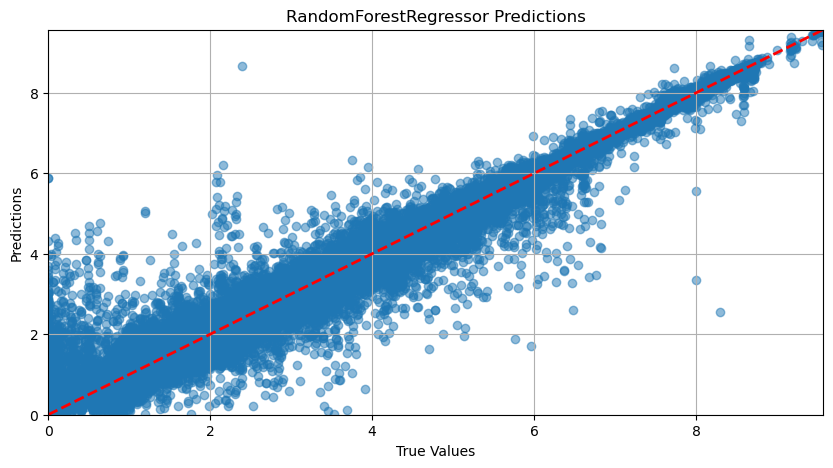

Learning Curves for: RandomForestRegressor


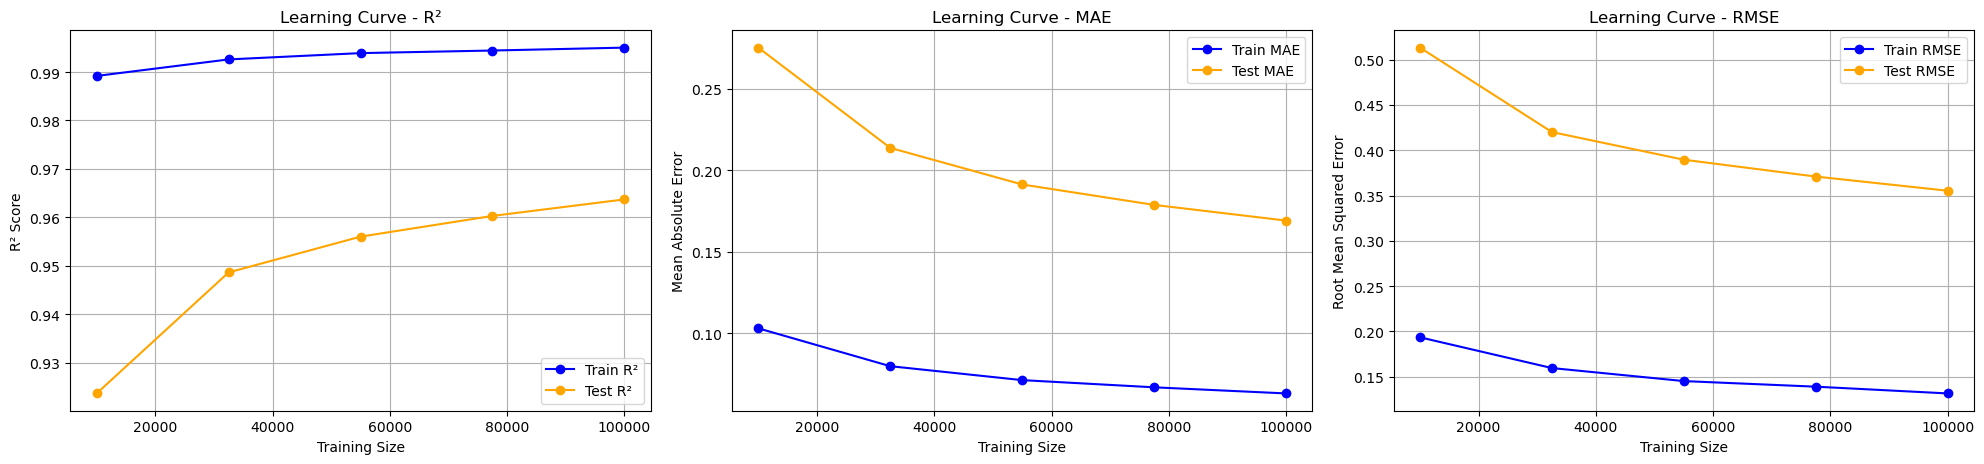

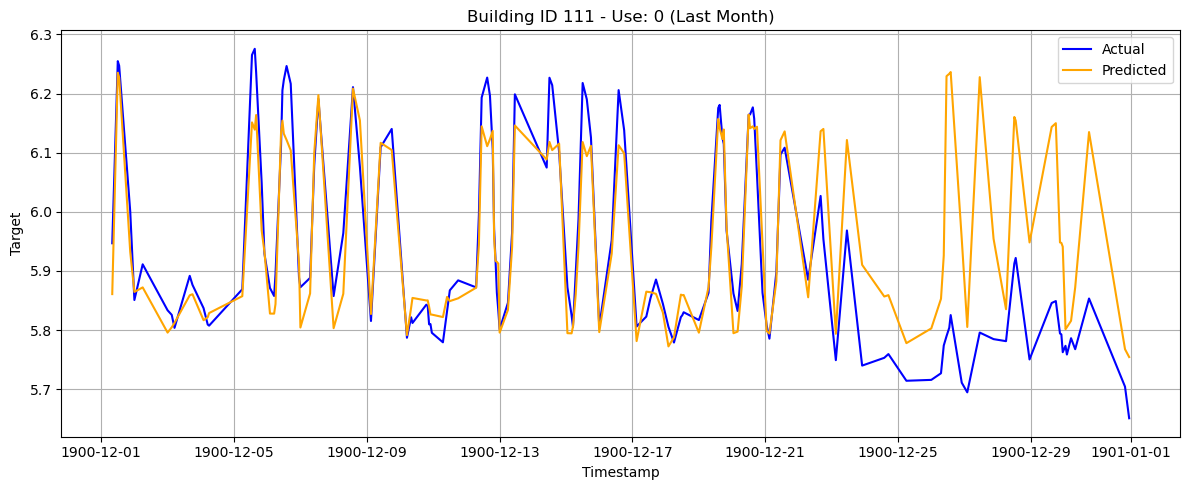

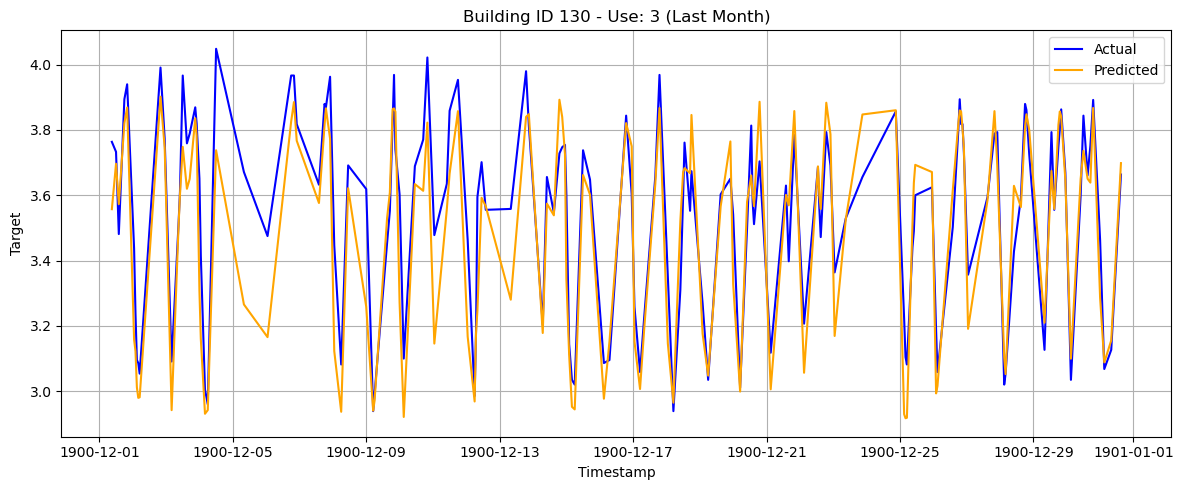

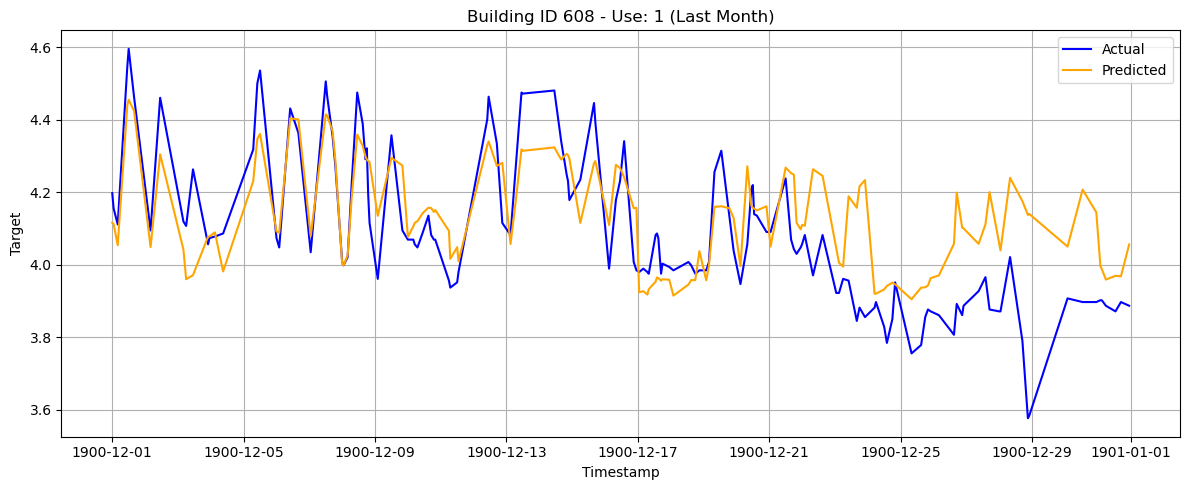

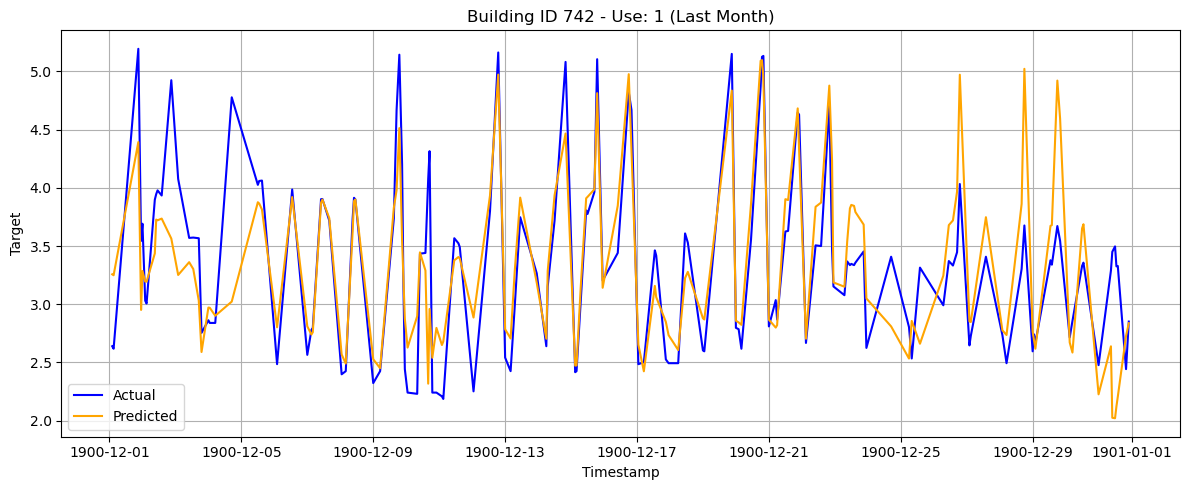

In [7]:
base_model = RandomForestRegressor(random_state=42)
md = train(base_model, X_train, X_test, y_train, y_test)

plot_building_predictions(md, X_test, y_test, df_test, building_ids=[111, 130, 608, 742])

Hyperparameter Tuning using RandomizedSearchCV for: RandomForestRegressor
Fitting 5 folds for each of 15 candidates, totalling 75 fits


/opt/anaconda3/envs/bolsa/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/bolsa/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/bolsa/lib/python3.10/site-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/bolsa/lib/python3.10/site-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  F

Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Training Model: RandomForestRegressor
Train - MAE: 0.0709, RMSE: 0.1377, R²: 0.9946, RMSLE: 0.0577
Test - MAE: 0.1036, RMSE: 0.2025, R²: 0.9883, RMSLE: 0.0794


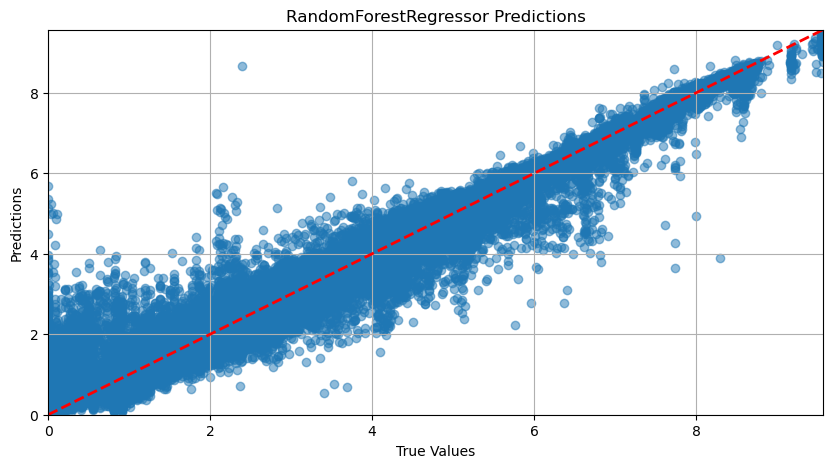

Learning Curves for: RandomForestRegressor


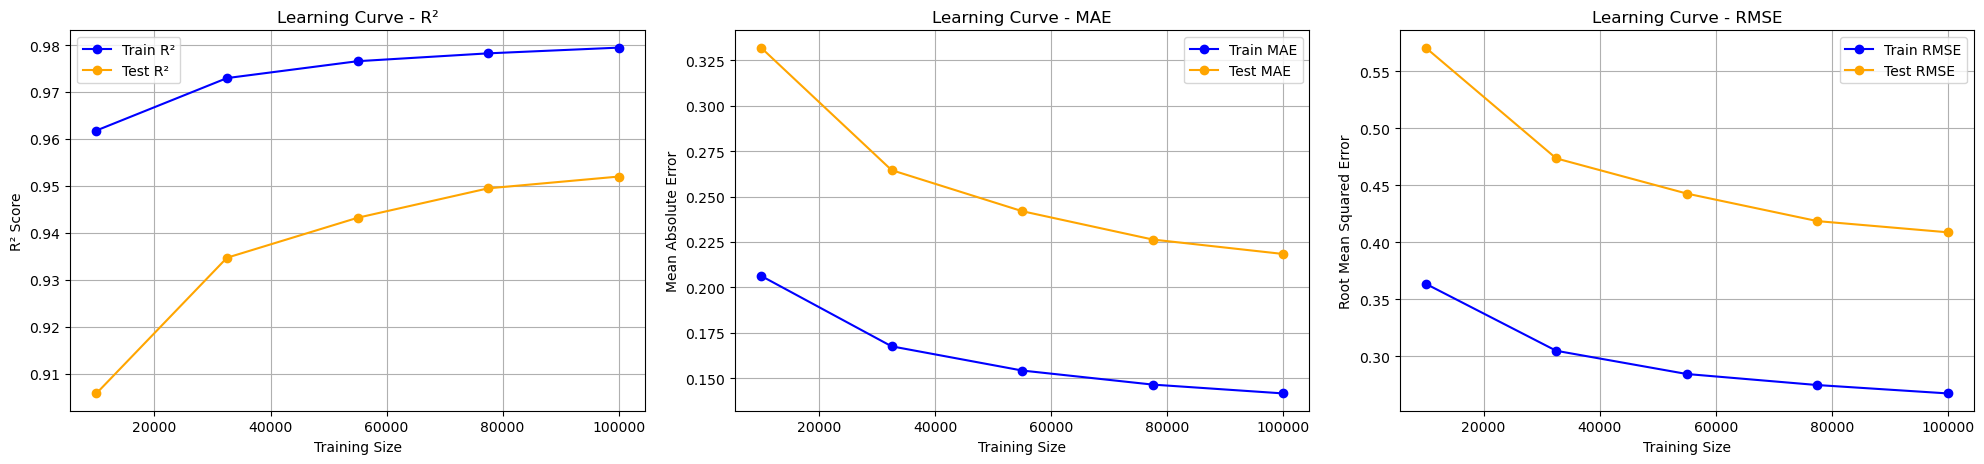

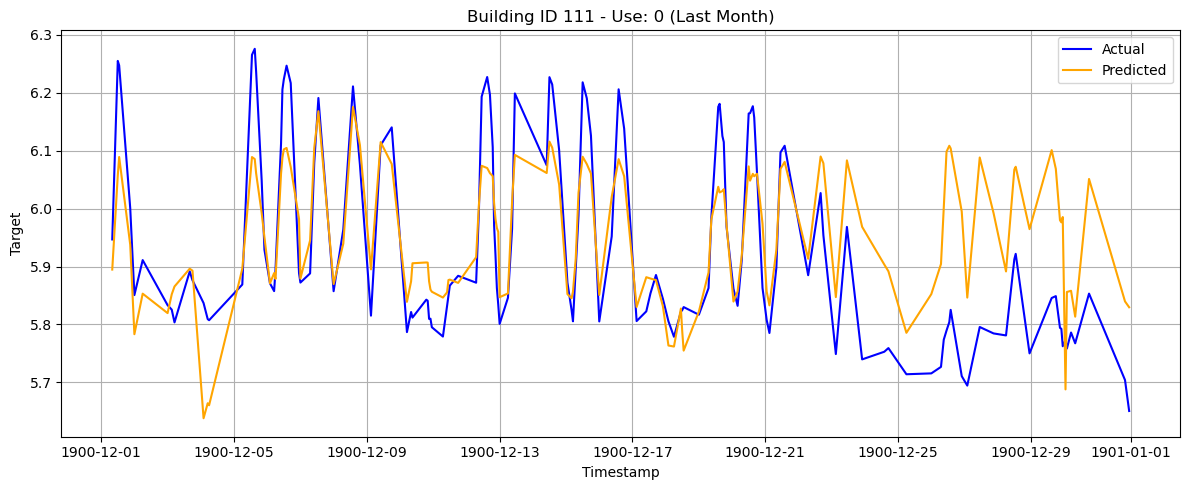

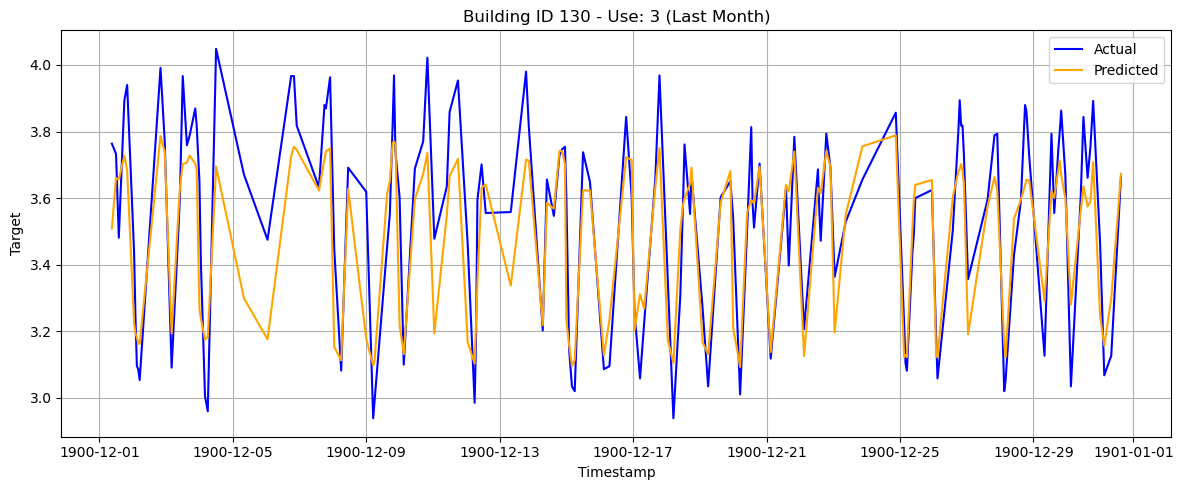

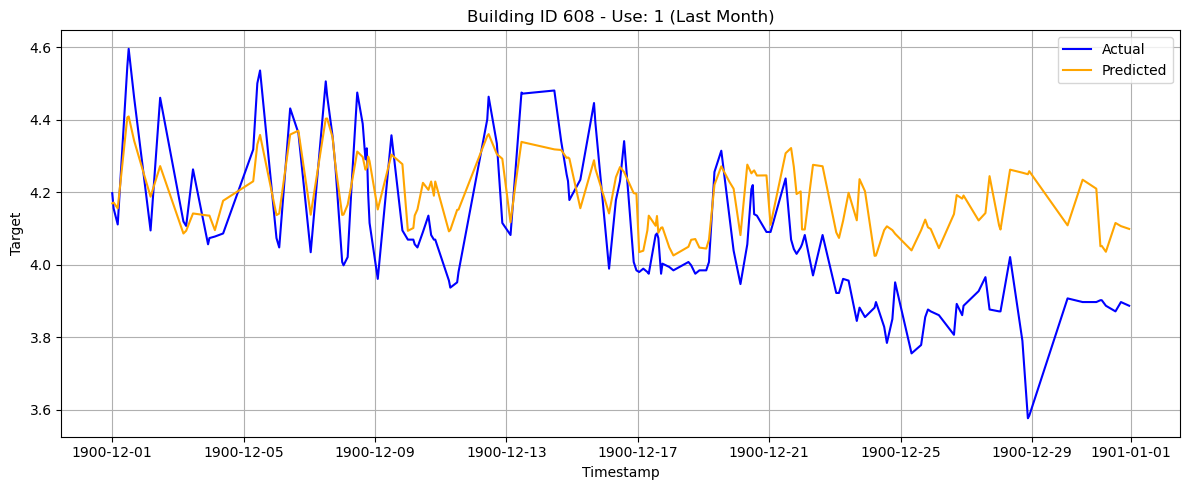

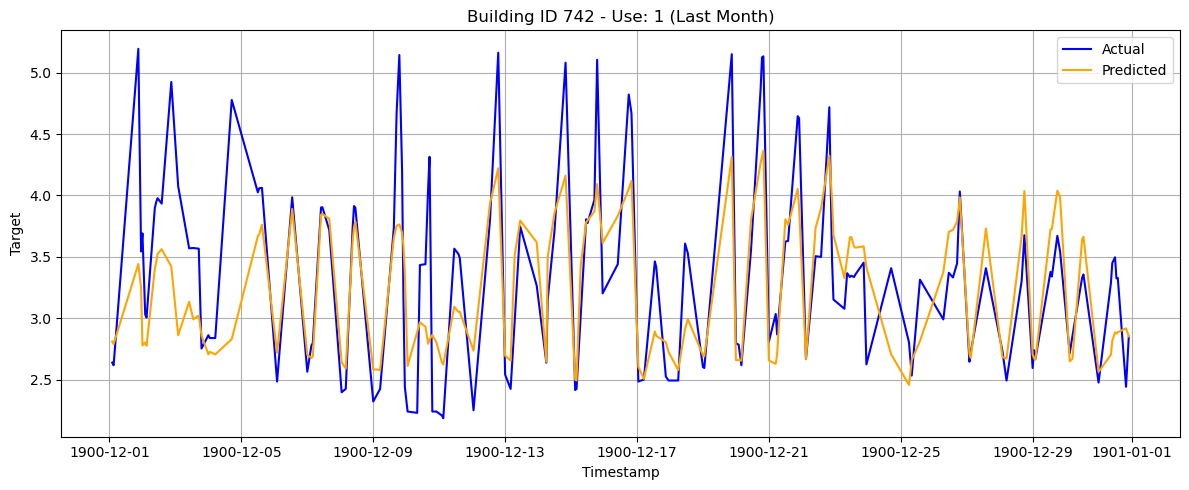

In [8]:
hyperparameters = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Ajuste de hiperparâmetros
best_params = hyper_parameter(base_model, hyperparameters, X_train, y_train, n_iter=15)

# Criar modelo com melhores parâmetros
model = RandomForestRegressor(**best_params, random_state=42)
md = train(model, X_train, X_test, y_train, y_test)

plot_building_predictions(md, X_test, y_test, df_test, building_ids=[111, 130, 608, 742])

K-Fold Cross Validation for: RandomForestRegressor


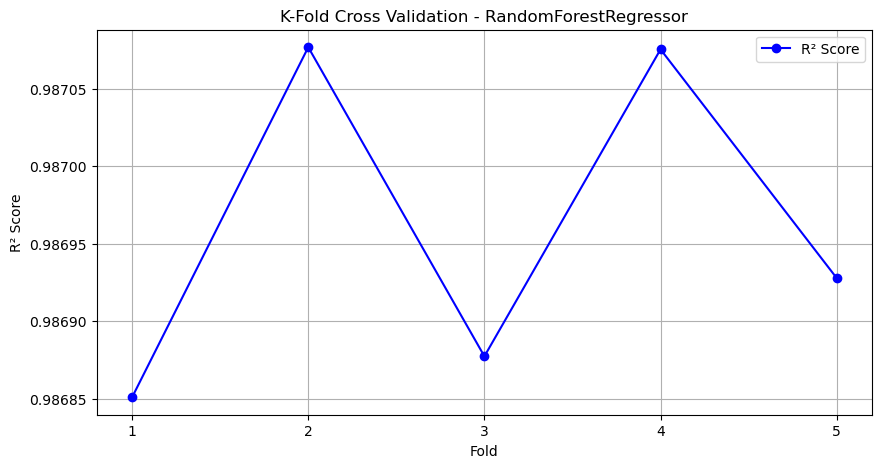

Best Model from K-Fold: RandomForestRegressor with R² Score: 0.9869
Training Model: RandomForestRegressor
Train - MAE: 0.0709, RMSE: 0.1377, R²: 0.9946, RMSLE: 0.0577
Test - MAE: 0.1036, RMSE: 0.2025, R²: 0.9883, RMSLE: 0.0794


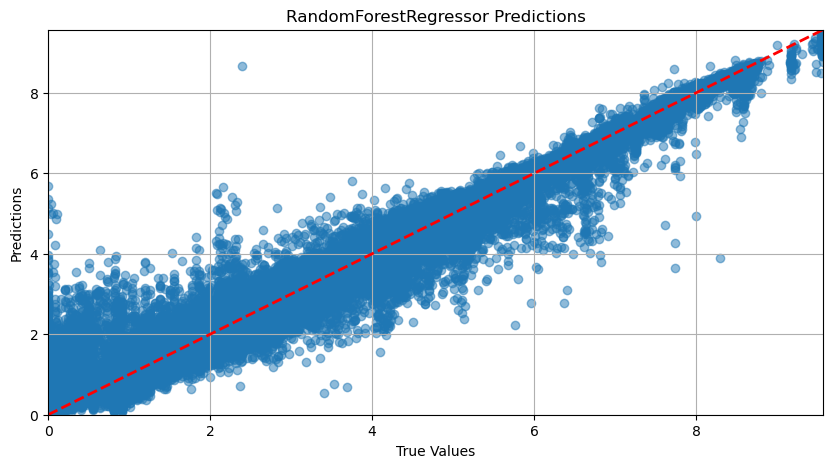

Learning Curves for: RandomForestRegressor


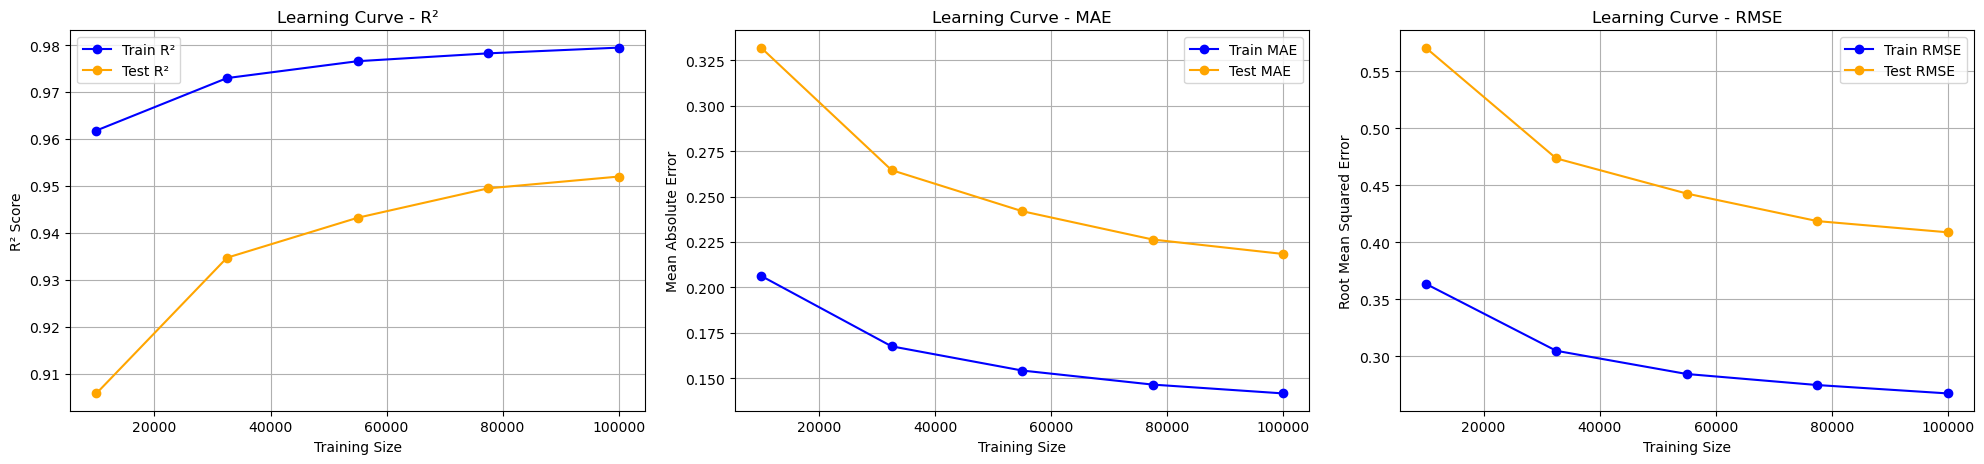

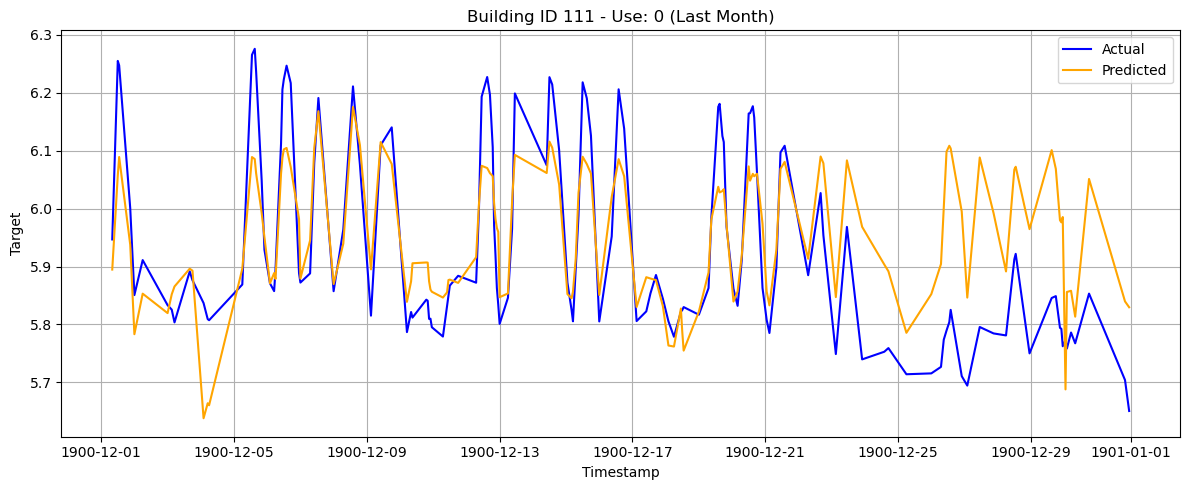

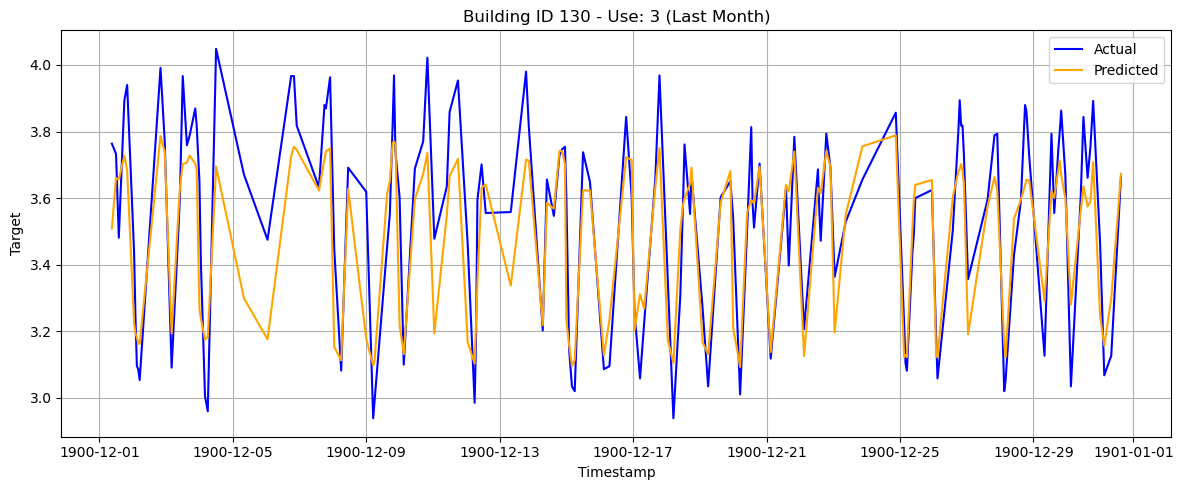

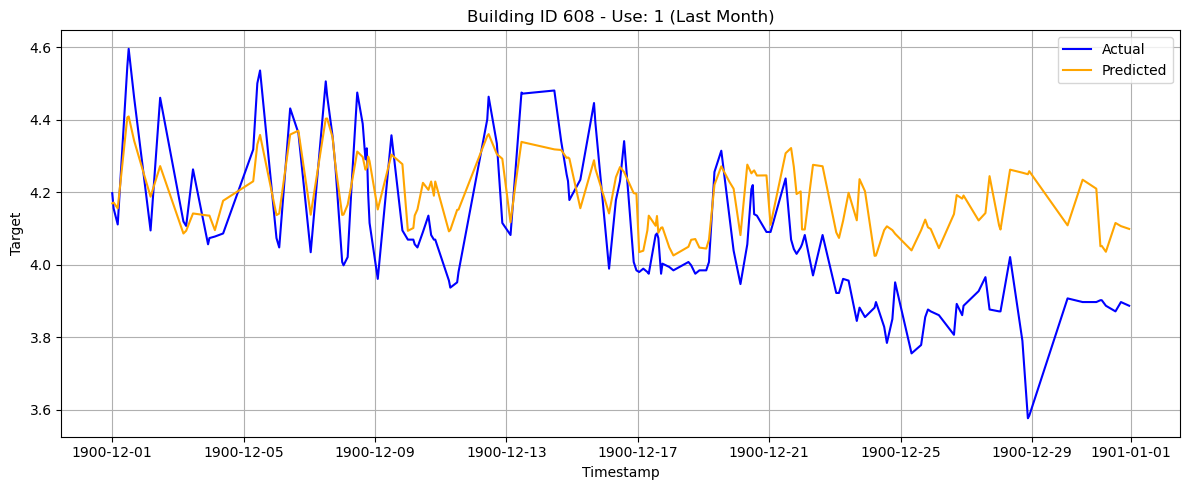

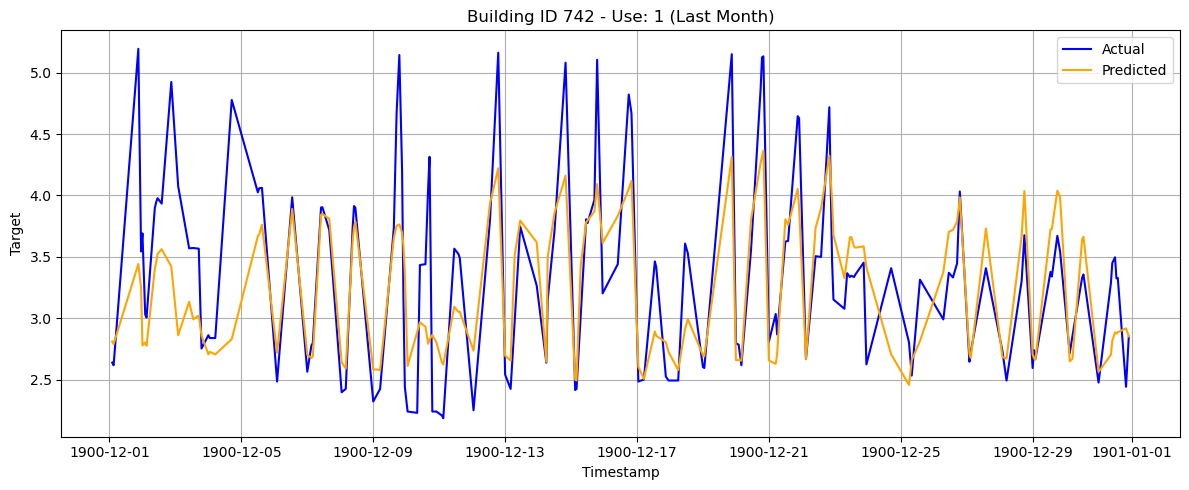

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
best_model = k_fold_cross_validation(model, 5, X_train, y_train)
# Train and evaluate the best model
trained_model = train(best_model, X_train, X_test, y_train, y_test)

plot_building_predictions(trained_model, X_test, y_test, df_test, building_ids=[111, 130, 608, 742])



Feature Importance:
             Feature  Importance
0        square_feet    0.279370
1        floor_count    0.201055
2       m2_per_floor    0.132230
3        building_id    0.115696
4         year_built    0.057398
5            site_id    0.053356
6              month    0.038186
7        primary_use    0.022651
8               hour    0.022245
9  precip_depth_1_hr    0.021908


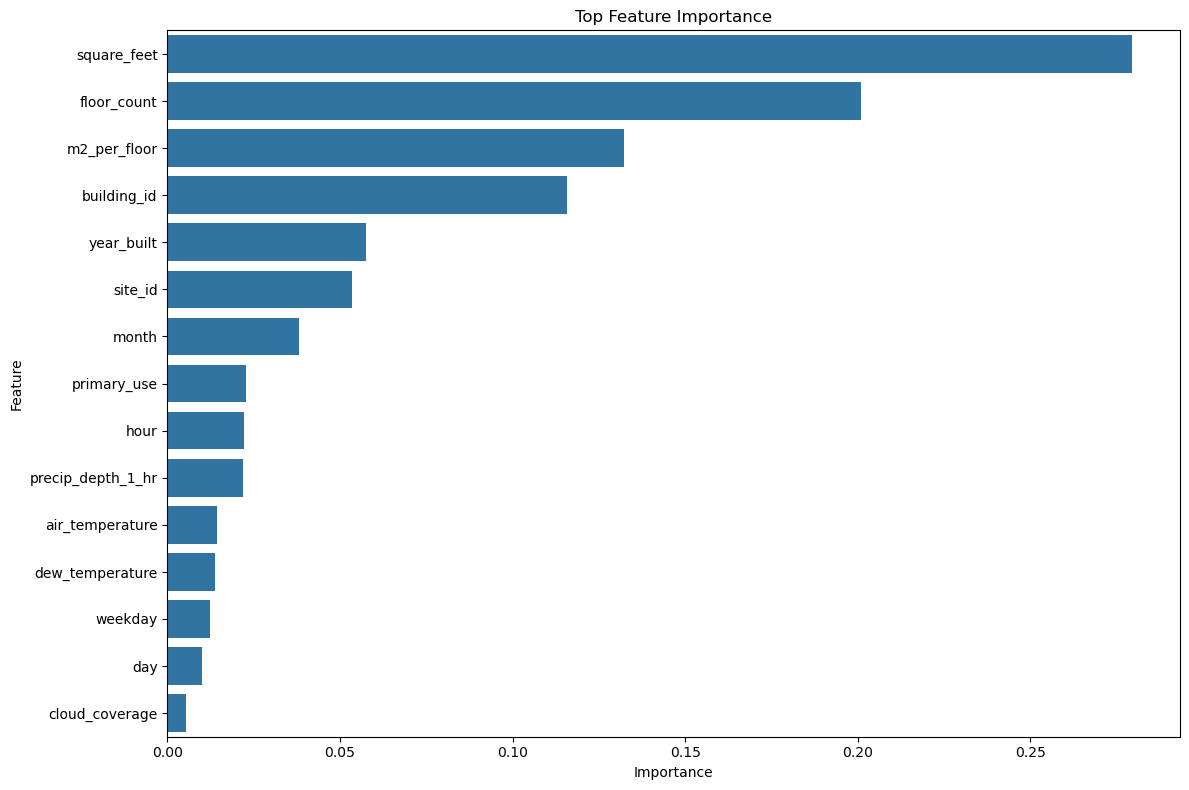

In [11]:
# Importância das features
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': trained_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
feature_importance.reset_index(drop=True, inplace=True)

print("Feature Importance:")
print(feature_importance.head(10))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top Feature Importance')
plt.tight_layout()
plt.show()
